# ART for scikit-learn ExtraTreeClassifier

In [1]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.classifiers import ScikitlearnExtraTreeClassifier
from art.attacks import ZooAttack, BoundaryAttack
from art.utils import load_mnist

# 1 Training scikit-learn ExtraTreeClassifier and attacking with ART Zeroth Order Optimization attack

In [2]:
def get_adversarial_examples(x_train, y_train):
    
    model = ExtraTreeClassifier(criterion='gini', splitter='random', max_depth=None, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, class_weight=None)

    # Fit ExtraTreeClassifier
    model.fit(X=x_train, y=y_train)
    
    # Create ART classifier for scikit-learn ExtraTreeClassifier
    art_classifier = ScikitlearnExtraTreeClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=10,
                    binary_search_steps=2, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)
    
    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)
    
    return x_train_adv, model

## 1.1 Utility functions

In [3]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] *= 2
    x_train[:, 1][y_train == 2] *= 2
    x_train[:, 0][y_train == 0] -= 3
    x_train[:, 1][y_train == 2] -= 2
    
    x_train[:, 0] = (x_train[:, 0] - 4) / (9 - 4)
    x_train[:, 1] = (x_train[:, 1] - 1) / (6 - 1)
    
    return x_train, y_train

In [4]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']
    
    for i_class in range(num_classes):
        
        # Plot difference vectors
        for i in range(y_train[y_train==i_class].shape[0]):
            x_1_0 = x_train[y_train==i_class][i, 0]
            x_1_1 = x_train[y_train==i_class][i, 1]
            x_2_0 = x_train_adv[y_train==i_class][i, 0]
            x_2_1 = x_train_adv[y_train==i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)
        
        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train==i_class_2][:, 0], x_train[y_train==i_class_2][:, 1], s=20, zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Show SVC predicted probability as contour plot
        h = .01
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z_proba = Z_proba[:, i_class].reshape(xx.shape)
        im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], vmin=0, vmax=1)
        if i_class == num_classes - 1:
            cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
            plt.colorbar(im, ax=axs[i_class],cax=cax)   
    
        # Plot adversarial samples
        for i in range(y_train[y_train==i_class].shape[0]):
            x_1_0 = x_train[y_train==i_class][i, 0]
            x_1_1 = x_train[y_train==i_class][i, 1]
            x_2_0 = x_train_adv[y_train==i_class][i, 0]
            x_2_1 = x_train_adv[y_train==i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].scatter(x_2_0, x_2_1, zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))
        
        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')

# 2 Example: Iris dataset

### legend
- colored background: probability of class i
- orange circles: class 1
- blue circles: class 2
- green circles: class 3
- red crosses: adversarial samples for class i

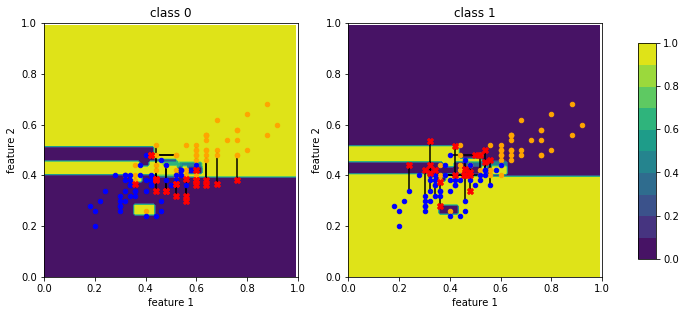

In [5]:
num_classes = 2
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

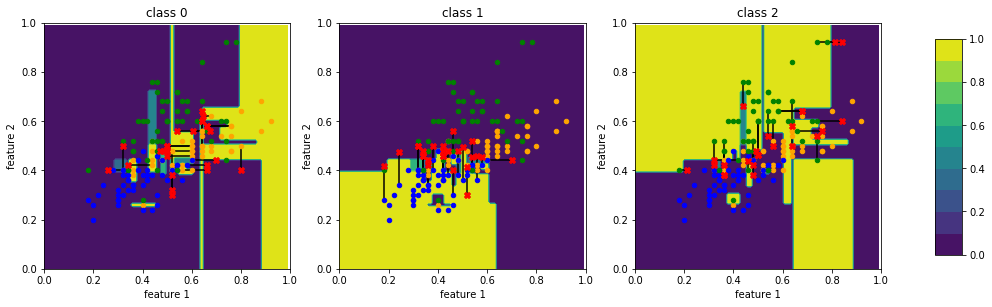

In [6]:
num_classes = 3
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

# 3 Example: MNIST

## 3.1 Load and transform MNIST dataset

In [7]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 200
x_train = x_train[0:n_samples_max]
y_train = y_train[0:n_samples_max]
x_test = x_test[0:n_samples_max]
y_test = y_test[0:n_samples_max]

## 3.2 Train ExtraTreeClassifier classifier

In [8]:
model = ExtraTreeClassifier(criterion='gini', splitter='random', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                            random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            min_impurity_split=None, class_weight=None)

In [9]:
model.fit(X=x_train, y=y_train)

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=None,
                    splitter='random')

## 3.3 Create and apply Zeroth Order Optimization Attack with ART

In [11]:
art_classifier = ScikitlearnExtraTreeClassifier(model=model)

In [12]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.05)

In [13]:
x_train_adv = zoo.generate(x_train)

In [14]:
x_test_adv = zoo.generate(x_test)

## 3.4 Evaluate ExtraTreeClassifier on benign and adversarial samples

In [15]:
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 1.0000


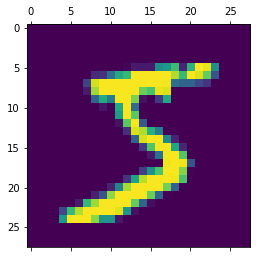

In [16]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [17]:
prediction = model.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 5


In [18]:
score = model.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.4550


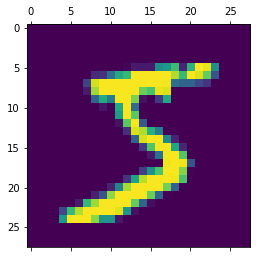

In [19]:
plt.matshow(x_train_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [20]:
prediction = model.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 5


In [21]:
score = model.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.4450


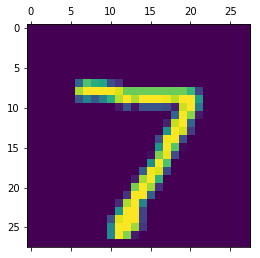

In [22]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [23]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 9


In [24]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2200


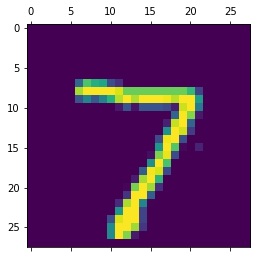

In [25]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [26]:
prediction = model.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 4
